# This File

* Pull runs from wandb to visualize data from
* Load data from tensorboard runs (currently functions to do this are in read_experiments.ipynb)
* Create plots used in progress report so far

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import wandb
import scipy.interpolate
import proplot as pplt

from read_experiments import *


entity = 'andyliu'
projects = ['GridNav_Reward_Shaping', 'GridNav_Visible_Platform_Colored_Walls', 
            'GridNav_Invisible_Reward_Colors', 'GridNav_Invisible_Reward_Poster']

api = wandb.Api()


# font = {'size' : 20,
#        'family': 'sans-serif',
#        'sans-serif': ['Helvetica'],
#        'serif': ['Palatino']}
# # font = {'size': 20,
# #         'family': 'serif',
# #         'serif': ['Palatino']}
# matplotlib.rc('font', **font)
# # matplotlib.rc('font.family', 'Helvetica')
# matplotlib.rc('text', usetex=True)
# axfont = {'fontname': 'Helvetica'}
# plt.rcParams['font.family'] = 'Helvetica'
# save_folder = 'plots/proof_of_concept/'





def get_runs(project_idx=0):
    '''
    Get iterrable of runs from the project
    Idxes fixed from projects list at top of jupyter notebook
    '''
    return api.runs(path=entity +'/' + projects[project_idx])


def get_metric(run, metrics=[], smoothing=0.01):
    '''
    Pull metrics from wandb run
    metrics: list of names of metrics to pull
    smoothing: whether to perform exponential smoothing on data
        False: no smoothing applied
        <val from 0-1>: smoothing parameter used
    '''
    data = run.history()
    df = data[['_step', 'global_step'] + metrics]
    df = df.dropna()
    if smoothing is not False:
        for metric in metrics:
            df.loc[:, metric+'_ewm'] = df[metric].ewm(alpha=smoothing).mean()
    return df



def plot_cloud_from_dict(datas, labels=None, data_col='charts/episodic_length_ewm',
                        ax=None, cloud_alpha=0.1, ignore_first=20000):
    '''
    Plot a cloud of trajectories build from dataframes from wandb into a dictionary
    The structure of the datas dictionary should be
    datas = {
        key1: [df1, df2, df3,...],
        key2: [df1, df2, df3,...],
        ...
    }
    Each df should have the 'global_step' data column in it to plot using (this is x-axis)
    data_col: column name in the df that contains the y-axis plot data
    cloud_alpha: opacity of max-min cloud
    ignore_first: how many timesteps of the start to ignore
    '''
    if ax is None:
        ax = plt
        ax.figure(figsize=(10, 10))
    
    for key in datas.keys():
        first_xs = []
        last_xs = []
        inters = []
        
        for j in range(len(datas[key])):
            df = datas[key][j]
            
            first_xs.append(df.iloc[0]['global_step'])
            last_xs.append(df.iloc[-1]['global_step'])

            inter = scipy.interpolate.interp1d(df['global_step'], df[data_col])
            inters.append(inter)
            
        min_x = np.max(first_xs)
        max_x = np.min(last_xs)
        xs = np.arange(min_x, max_x, 200)
        ys = np.zeros((len(datas[key]), len(xs)))

        for j in range(len(datas[key])):
            ys[j] = inters[j](xs)
        
        if ignore_first is not None:
            idx = np.argmax(xs > ignore_first)
            xs = xs[idx:]
            ys = ys[:, idx:]
        
        ax.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=cloud_alpha)
        if labels is not None:
            ax.plot(xs, ys.mean(axis=0), label=labels[key])
        else:
            ax.plot(xs, ys.mean(axis=0))
            
    if labels is not None:
        ax.legend()
        

    

# Checking episodic returns for different reward shaping params

Visible platform, use 4 different reward shaping modes - each experiment contains 10 trials
* Reward only on goal reached, 1 point rewarded
* Reward proportional to how close agent is to goal (closeness) with max of 0.01 rewarded, and 1 point on reaching goal
* Reward closeness when goal is in sight, and on goal reached
* Reward closeness once goal has been seen at least once, and on goal reached

Learning seems to be possible without any additional reward shaping, but any sort of reward shaping improves learning process. 

In future case, if training with reward shaping, we assume to use only the first method (closeness rewarded no matter if goal is in sight)

In [5]:
#collect data from wandb
runs = get_runs(0)
shapes = [[] for i in range(4)]

for i, run in enumerate(runs):
    if run.state == 'finished':
        shape = run.config['env_kwargs']['reward_shaping']
        metrics = run.history()
        df = metrics[['_step', 'global_step', 'charts/episodic_length']]
        df = df.dropna()
        df.loc[:, 'ewm'] = df['charts/episodic_length'].ewm(alpha=0.01).mean()
        shapes[shape].append(df)


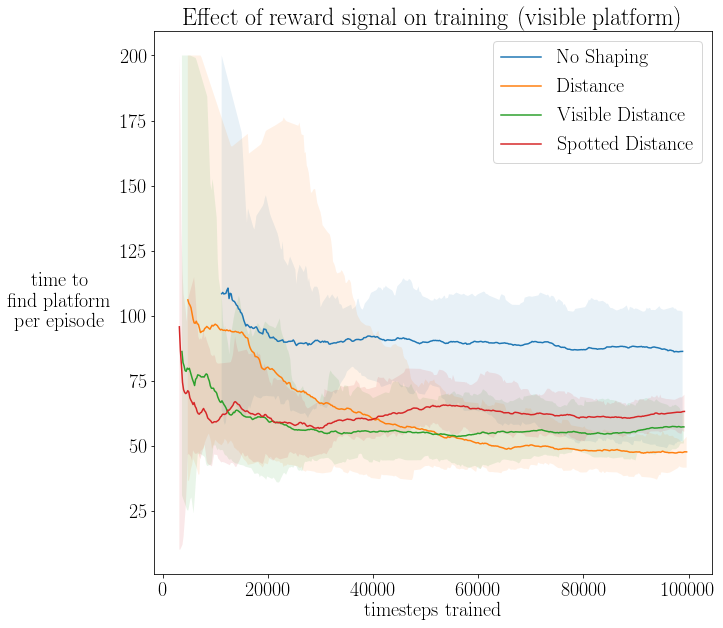

In [9]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plt.figure(figsize=(10, 10))

labels = ['No Shaping', 'Distance', 'Visible Distance', 'Spotted Distance']
for i in range(4):
    # plot_x, plot_y = 
    first_xs = []
    last_xs = []
    inters = []
    for j in range(len(shapes[i])):
        df = shapes[i][j]

        first_xs.append(df.iloc[0]['global_step'])
        last_xs.append(df.iloc[-1]['global_step'])

        inter = scipy.interpolate.interp1d(df['global_step'], df['ewm'])
        inters.append(inter)

        # plt.plot(df['global_step'], df['ewm'])

    min_x = np.max(first_xs)
    max_x = np.min(last_xs)
    xs = np.arange(min_x, max_x, 200)
    ys = np.zeros((len(shapes[i]), len(xs)))

    for j in range(len(shapes[i])):
        ys[j] = inters[j](xs)

    plt.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=0.1)
    plt.plot(xs, ys.mean(axis=0), label=labels[i])
    
plt.legend()
plt.title('Effect of reward signal on training (visible platform)')
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained')

plt.savefig(save_folder + '1_reward_shaping.png', bbox_inches='tight')

# Wall colors with visible platform

Next check the effect of having different wall colors on finding goal (can adding colors to walls improve navigability of pool?) - each experiment contains 10 trials
* All red
* Red/Green walls symmetrical (red, green, red, green)
* Red/Green walls asymmetrical (red, red, green, green)
* All walls different colors

Here all cases are trained with reward shaping. We find that adding wall colors does not significantly improve navigability based on learning curve (although we might be inclined to test other measures, such as search strategy, for example, may want to test taking platform away entirely)

However, adding 4 wall colors leads to more confounding information to be learned and slows learning. Asymptotically, performance converges between different cases

Note that here, we are using an LSTM network. This network structure theoretically allows the agent to learn latent world information (such as where the agent has navigated and visited), thus it would not necessarily need Markovian conditions for navigation

In [34]:
colors = [1, 2, 2.5, 4]
datas = [[] for i in range(len(colors))]

runs = get_runs(1)
for i, run in enumerate(runs):
    # print(run.summary['global_step'])
    if run.state == 'finished' and run.summary['global_step'] > 200000:
        color = run.config['env_kwargs']['wall_colors']
        metrics = run.history()
        df = metrics[['_step', 'global_step', 'charts/episodic_length']]
        df = df.dropna()
        df.loc[:, 'ewm'] = df['charts/episodic_length'].ewm(alpha=0.01).mean()
        datas[colors.index(color)].append(df)
        



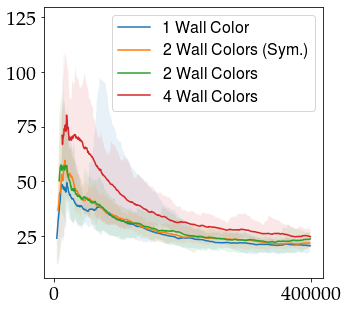

In [35]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plt.figure(figsize=(5, 5))

labels = ['1 Wall Color', '2 Wall Colors (Sym.)', '2 Wall Colors', '4 Wall Colors']
for i in range(4):
    # plot_x, plot_y = 
    first_xs = []
    last_xs = []
    inters = []
    for j in range(len(datas[i])):
        df = datas[i][j]

        first_xs.append(df.iloc[0]['global_step'])
        last_xs.append(df.iloc[-1]['global_step'])

        inter = scipy.interpolate.interp1d(df['global_step'], df['ewm'])
        inters.append(inter)

        # plt.plot(df['global_step'], df['ewm'])

    min_x = np.max(first_xs)
    max_x = np.min(last_xs)
    xs = np.arange(min_x, max_x, 200)
    ys = np.zeros((len(datas[i]), len(xs)))

    for j in range(len(datas[i])):
        ys[j] = inters[j](xs)

    plt.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=0.1)
    plt.plot(xs, ys.mean(axis=0), label=labels[i])
    

    
plt.legend(fontsize=16)
plt.xticks([0, 400000])
# plt.title('Effect of wall colors on training (visible platform, reward shaping 1)')
# plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60,
#           **axfont)
# plt.xlabel('timesteps trained', **axfont)

plt.savefig(save_folder + '2_visible_platform_wall_colors', bbox_inches='tight')

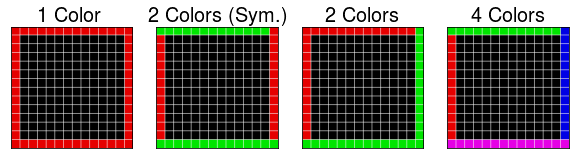

In [37]:
def render(self, mode='human', ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(8, 8))
    window_size = [(self.world_size[0]) * 16, (self.world_size[1]) * 16]

    img = np.zeros(window_size + [3])

    #draw grid
    img[np.arange(0, window_size[0], 16), :, :] = 1
    img[:, np.arange(0, window_size[1], 16), :] = 1

    def color_block(x, y, rgb, img):
        img[y*16+1:(y+1)*16, x*16+1:(x+1)*16] = rgb
        return img

    #draw solid objects
    for i in range(self.world_size[0]):
        for j in range(self.world_size[1]):
            if self.visible[i, j] != 0:
                # print(i)
                # img[i*16+1:(i+1)*16, j*16+1:(j+1)*16] = self.idx_to_rgb[self.visible[i, j]]
                img = color_block(j, i, self.idx_to_rgb[self.visible[i, j]], img)
            elif self.objects[i, j] != 0:
                #draw invisible objects for viewer
                img = color_block(j, i, [0.6, 0.6, 0.6], img)

    if mode == 'rgb_array':
        # return img.astype('uint8') * 255
        return (img * 255).astype('uint8')
    elif mode == 'human':
        ax.imshow(img)


import gym
import gym_nav

colors = [1, 2, 2.5, 4]
label_list = ['1 Color', '2 Colors (Sym.)', '2 Colors', '4 Colors']


fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for x, color in enumerate(colors):
    env = gym.make('Gridworld-v0', num_obstacles=0, world_size=14, wall_colors=color)
    env.render = render
    for i in range(1, 13):
        for j in range(1, 13):
            env.visible[i, j] = 0
            env.objects[i, j] = 0
    env.agent[0] = [1, 1]
    env.agent[1] = 0
    env.render(env, ax=ax[x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])
    ax[x].set_title(label_list[x], fontsize=20)
plt.savefig(save_folder + '2a_wall_colors.png', bbox_inches='tight')

# Invisible goal with different wall colors

Next, we test making the platform invisible, and seeing whether wall colors now improve navigability or not

**Note here that the platform always has the same position, so the challenge is to determine where you are in relation to the platform**

Same wall colors as the previous experiment. Here we see a strong heterogeneity with performance depending on wall colors

For the 2 wall color and 4 wall color scenarios, there is asymmetry that can be relied on for navigation. For 1 wall color and 2 symmetrical wall colors, global information that is provided by the walls decreases.

Something suspicious happens with 1 wall color however - the trajectory cloud is much wider


## Shaped reward

This gives a slightly clearer picture of the effect of wall colors on training, decreasing how much the randomness of seeds (i.e., on whether or not the agent randomly stumbles on goal) affects the training trajectory

In [11]:
runs = get_runs(2)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 1 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

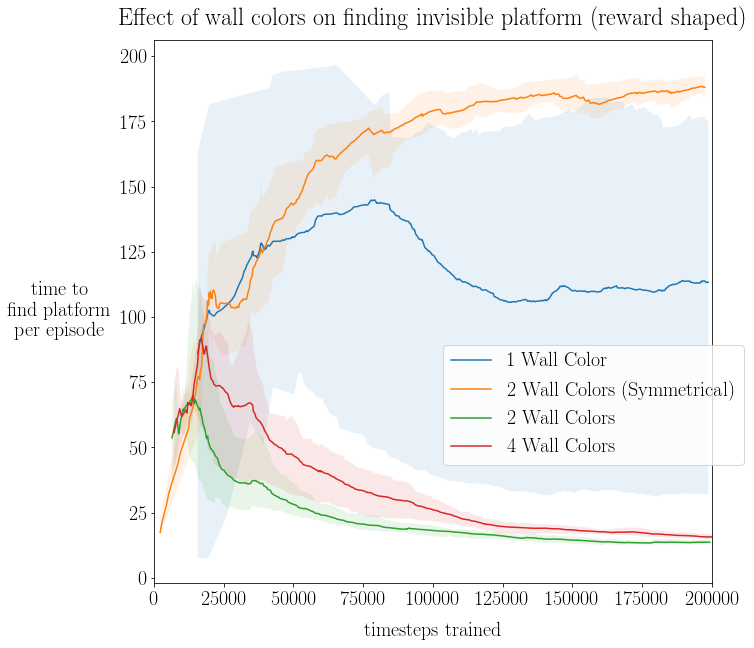

In [12]:
plot_cloud_from_dict(datas, labels)
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained', labelpad=15)
plt.xlim([0, 200000])
plt.title('Effect of wall colors on finding invisible platform (reward shaped)', pad=15)
plt.legend(bbox_to_anchor=(0.5, 0.2, 0, 0))

plt.savefig(save_folder + '3_1_invisible_wall_colors_shaped_reward', bbox_inches='tight')

## Non-shaped reward

This is a good visual indication of randomness effect on training

In [2]:
runs = get_runs(2)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 0 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

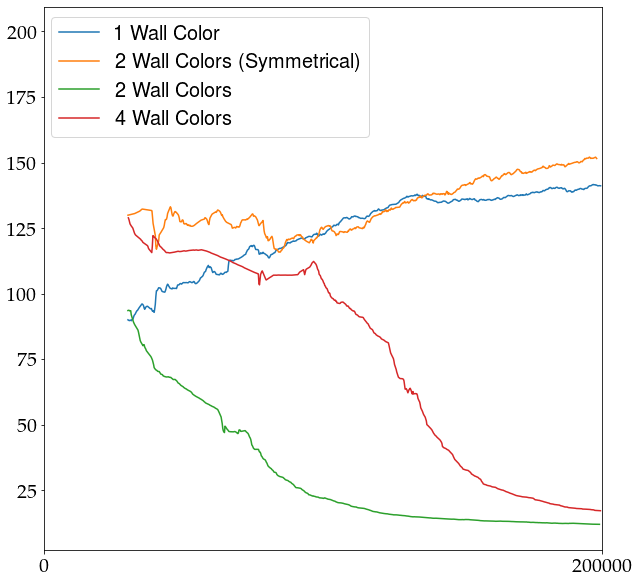

In [10]:
plot_cloud_from_dict(datas, labels, cloud_alpha=0, ignore_first=30000t)
# plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
# plt.xlabel('timesteps trained', labelpad=15)
plt.xlim([0, 200000])
plt.xticks([0, 200000])
# plt.title('Effect of wall colors on finding invisible platform (no reward shaping)', pad=15)
plt.legend(bbox_to_anchor=(0.6, 1, 0, 0))

plt.savefig(save_folder + '3_2_invisible_wall_colors_nonshaped_reward', bbox_inches='tight')

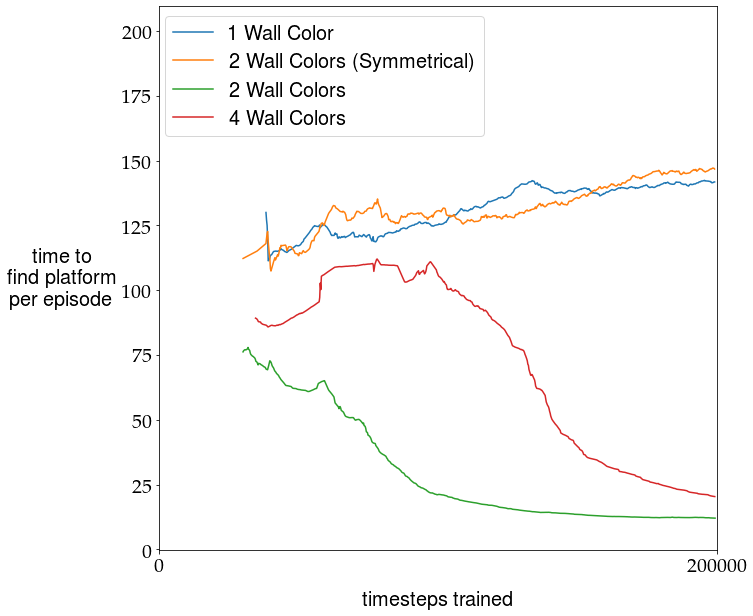

In [4]:
plot_cloud_from_dict(datas, labels, cloud_alpha=0, ignore_first=30000)
plt.xlim([0, 200000])
plt.xticks([0, 200000])
# plt.title('Effect of wall colors on finding invisible platform (no reward shaping)', pad=15)
plt.legend(bbox_to_anchor=(0.6, 1, 0, 0))

plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained', labelpad=15)

plt.savefig(save_folder + '3_2_invisible_wall_colors_nonshaped_reward_axes', bbox_inches='tight')

## Combined plots

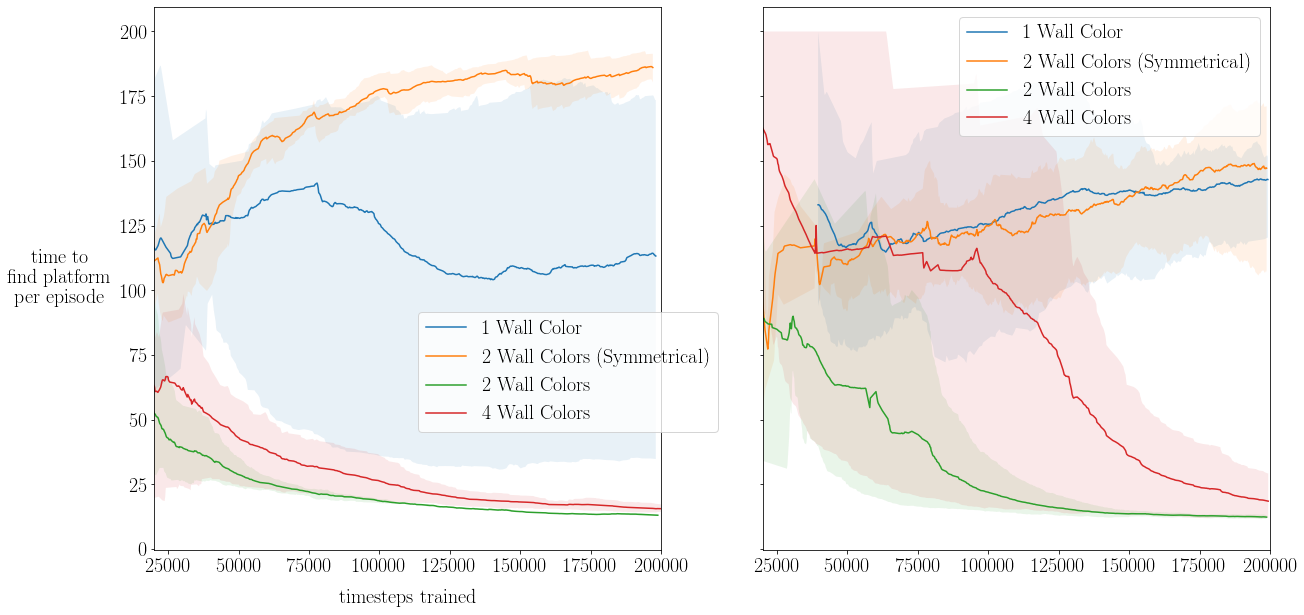

In [20]:
runs = get_runs(2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 1 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, labels, ax=ax[0])
ax[0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
ax[0].set_xlabel('timesteps trained', labelpad=15)
ax[0].set_xlim([20000, 200000])
ax[0].legend(bbox_to_anchor=(0.5, 0.2, 0, 0))

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 0 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, labels, ax=ax[1])

plt.savefig(save_folder + '4_3_invisible_wall_colors', bbox_inches='tight')

## Individual Trials 1 Wall Color

Here it is clear that there is some learning that is possible (especially with reward shaping). Here, each trajectory represents a different random instantiation of the training regiment

In [131]:
runs = get_runs(2)

shapes = [0, 1]
datas = {shape: [] for shape in shapes}
for run in runs:
    if run.state == 'finished' and run.config['env_kwargs']['wall_colors'] == 1 and \
        run.summary['global_step'] > 300000 :
        shape = run.config['env_kwargs']['reward_shaping']
        df = get_metric(run, ['charts/episodic_length'])
        datas[shape].append(df)

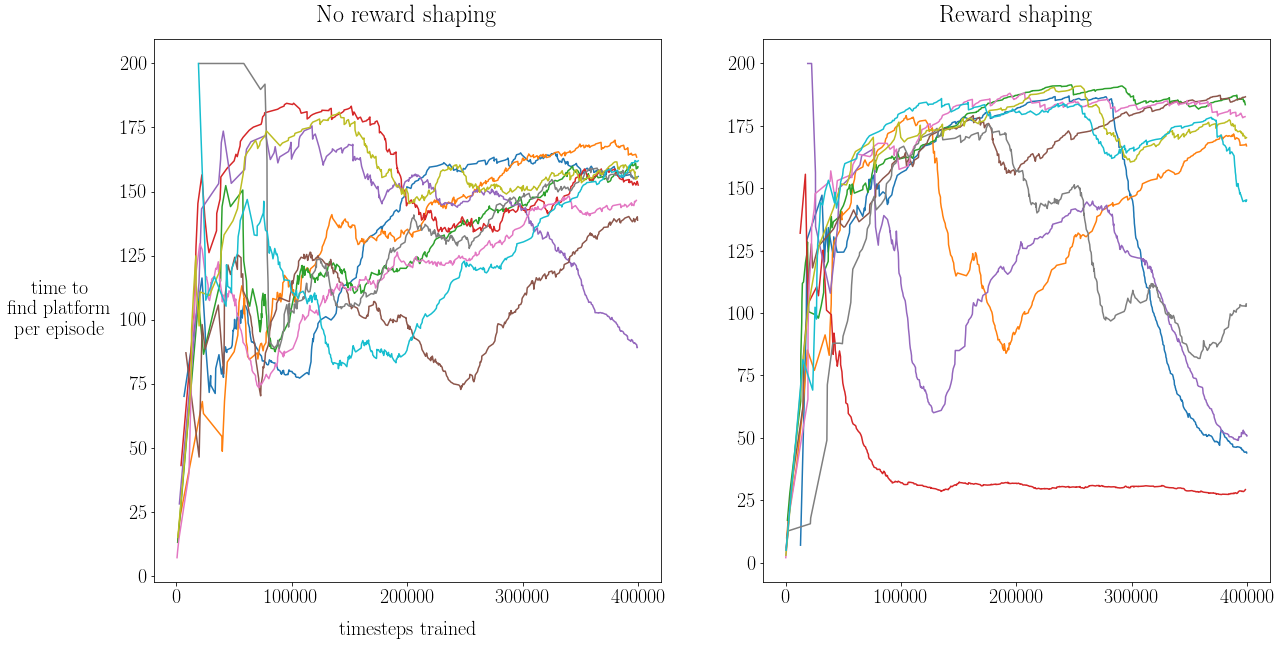

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))



for x, shape in enumerate(shapes):
    for i in range(len(datas[shape])):
        df = datas[shape][i]
        ax[x].plot(df['global_step'], df['charts/episodic_length_ewm'])
        

ax[0].set_ylabel('time to\nfind platform\nper episode', labelpad=60, rotation=0, va='center')
ax[0].set_xlabel('timesteps trained', labelpad=15)
ax[0].set_title('No reward shaping', pad=15)
ax[1].set_title('Reward shaping', pad=15)

plt.savefig(save_folder + '3_3_single_wall_color_individual_trials.png', bbox_inches='tight')

# Poster Examples

Here we simulate "hanging posters" on the wall to provide the asymmetry / global cue to navigate by

There is a close poster case vs a far poster case

Here clearly, the close poster does indeed make navigation easier. What is slightly harder to understand is why remove reward shaping seems to significantly improve training in the close poster case. This may be because the reward signal is slightly confounding, where you need to turn to look at and use the poster for navigation, but the reward shaping subgoal incentivizes you to move forward primarily rather than turn.

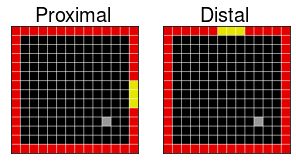

In [38]:
def render(self, mode='human', ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(8, 8))
    window_size = [(self.world_size[0]) * 16, (self.world_size[1]) * 16]

    img = np.zeros(window_size + [3])

    #draw grid
    img[np.arange(0, window_size[0], 16), :, :] = 1
    img[:, np.arange(0, window_size[1], 16), :] = 1

    def color_block(x, y, rgb, img):
        img[y*16+1:(y+1)*16, x*16+1:(x+1)*16] = rgb
        return img

    #draw solid objects
    for i in range(self.world_size[0]):
        for j in range(self.world_size[1]):
            if self.visible[i, j] != 0:
                # print(i)
                # img[i*16+1:(i+1)*16, j*16+1:(j+1)*16] = self.idx_to_rgb[self.visible[i, j]]
                img = color_block(j, i, self.idx_to_rgb[self.visible[i, j]], img)
            elif self.objects[i, j] != 0:
                #draw invisible objects for viewer
                img = color_block(j, i, [0.6, 0.6, 0.6], img)

    if mode == 'rgb_array':
        # return img.astype('uint8') * 255
        return (img * 255).astype('uint8')
    elif mode == 'human':
        ax.imshow(img)


import gym
import gym_nav

posters = [0, 1]
label_list = ['Proximal', 'Distal']


fig, ax = plt.subplots(1, 2, figsize=(5, 3))

for x, poster in enumerate(posters):
    env = gym.make('Gridworld-v0', num_obstacles=0, world_size=14, wall_colors=1, poster=poster,
                  task_structure=2)
    env.render = render
    env.agent[0] = [1, 1]
    env.agent[1] = 0
    env.render(env, ax=ax[x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])
    ax[x].set_title(label_list[x], fontsize=20)
plt.savefig(save_folder + '4a_posters.png', bbox_inches='tight')

In [5]:
runs = get_runs(3)
posters = [0, 1]
datas0 = {poster: [] for poster in posters} #not shaped
datas1 = {poster: [] for poster in posters} #shaped
labels_list = ['Proximal Poster', 'Distal Poster']
labels = {posters[i]: labels_list[i] for i in range(2)}
for run in runs:
    if run.state == 'finished' and run.config['env_kwargs']['reward_shaping'] == 1: 
        poster = run.config['env_kwargs']['poster']
        df = get_metric(run, ['charts/episodic_length'])
        datas1[poster].append(df)
    elif run.state == 'finished' and run.config['env_kwargs']['reward_shaping'] == 0:
        poster = run.config['env_kwargs']['poster']
        df = get_metric(run, ['charts/episodic_length'])
        datas0[poster].append(df)


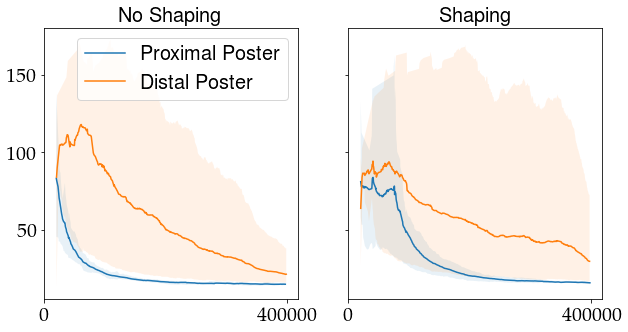

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
plot_cloud_from_dict(datas0, labels, ax=ax[0])
plot_cloud_from_dict(datas1, ax=ax[1])

ax[0].set_title('No Shaping', fontsize=20)
ax[1].set_title('Shaping', fontsize=20)

# ax[0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
# ax[0].set_xlabel('timesteps trined', labelpad=15)

ax[0].set_xticks([0, 400000])
plt.savefig(save_folder + '4_poster_training.png', bbox_inches='tight')

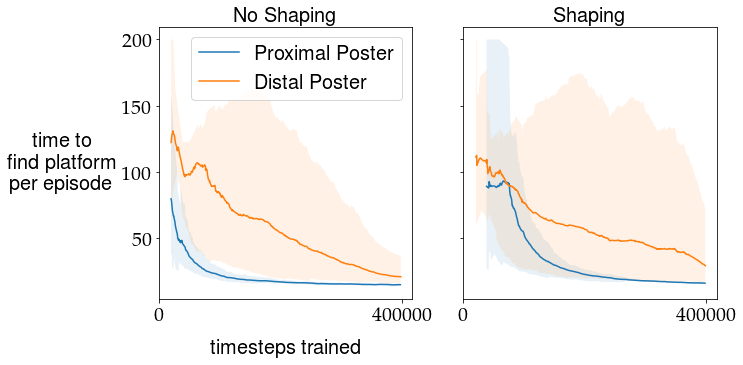

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
plot_cloud_from_dict(datas0, labels, ax=ax[0])
plot_cloud_from_dict(datas1, ax=ax[1])

ax[0].set_title('No Shaping', fontsize=20)
ax[1].set_title('Shaping', fontsize=20)

ax[0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
ax[0].set_xlabel('timesteps trained', labelpad=15)

ax[0].set_xticks([0, 400000])
plt.savefig(save_folder + '4_poster_training_axes.png', bbox_inches='tight')

# Continuous Navigation

## Wall Colors

## Reward shaping wall colors grid and continuous

Collection of all of the learning curves for both grid and continuous navigation with different wall colors


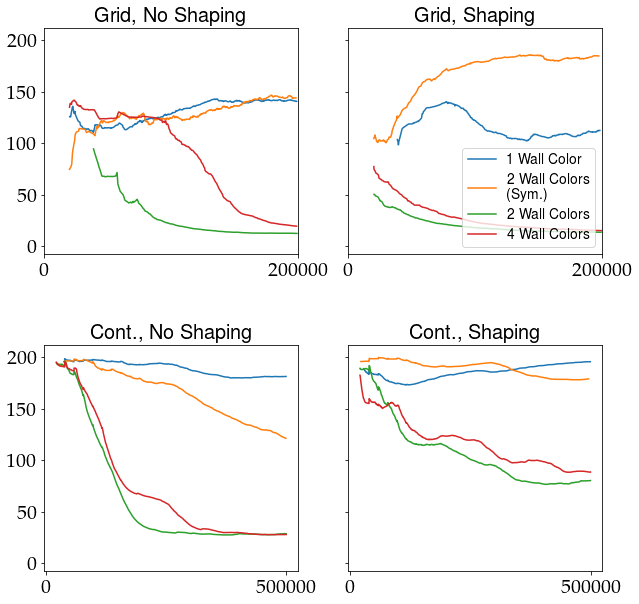

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='row', sharey=True)    

# runs = get_runs(2)

# Grid navigation (first row)
colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 1 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, ax=ax[0, 1], cloud_alpha=0)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 0 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, ax=ax[0, 0], cloud_alpha=0)



# Continuous navigation plots (2nd row)
colors = ['1', '2', '2.5', '4']
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
dist_trial_names = [f'nav_invisible_color_{color}_dist' for color in colors]
none_trial_names = [f'nav_invisible_color_{color}_none' for color in colors]
labels = ['1 Wall Color', '2 Wall Colors \n(Sym.)', '2 Wall Colors', '4 Wall Colors']

for i, trial in enumerate(dist_trial_names):
    average_runs(trial, 'length', label=labels[i], ax=ax[1, 1], ignore_first=90, color=color_cycle[i], cloud_alpha=0,
                ewm=0.001)
for i, trial in enumerate(none_trial_names):
    average_runs(trial, 'length', label=labels[i], ax=ax[1, 0], ignore_first=90, color=color_cycle[i], cloud_alpha=0,
                ewm=0.001)

    
# ax[1, 0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
# ax[1, 0].set_xlabel('timesteps trained', labelpad=15)
ax[0, 0].set_xlim([0, 200000])

ax[0, 0].set_xticks([0, 200000])
ax[1, 0].set_xticks([0, 500000])

# ax[0, 1].set_xlim([15000, 200000])
handles, labels = ax[1,0].get_legend_handles_labels()
# ax[0, 0].legend(loc='lower right', bbox_to_anchor=(1.5,-), fontsize=12)
# fig.legend(handles, labels, loc='upper left', fontsize=12, bbox_to_anchor=(-0.10, 0.88))

# ax[0, 0].text(30000, 170, 'A', weight='bold')
# ax[0, 1].text(30000, 170, 'B', weight='bold')
# ax[1, 0].text(30000, 30, 'C', weight='bold')
# ax[1, 1].text(30000, 30, 'D', weight='bold')

ax[0, 1].legend(handles, labels, fontsize=14, loc='lower right')

ax[0, 0].set_title('Grid, No Shaping', fontsize=20)
ax[0, 1].set_title('Grid, Shaping', fontsize=20)
ax[1, 0].set_title('Cont., No Shaping', fontsize=20)
ax[1, 1].set_title('Cont., Shaping', fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.savefig(save_folder + '7_2_grid_and_cont_wall_color_shaping', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


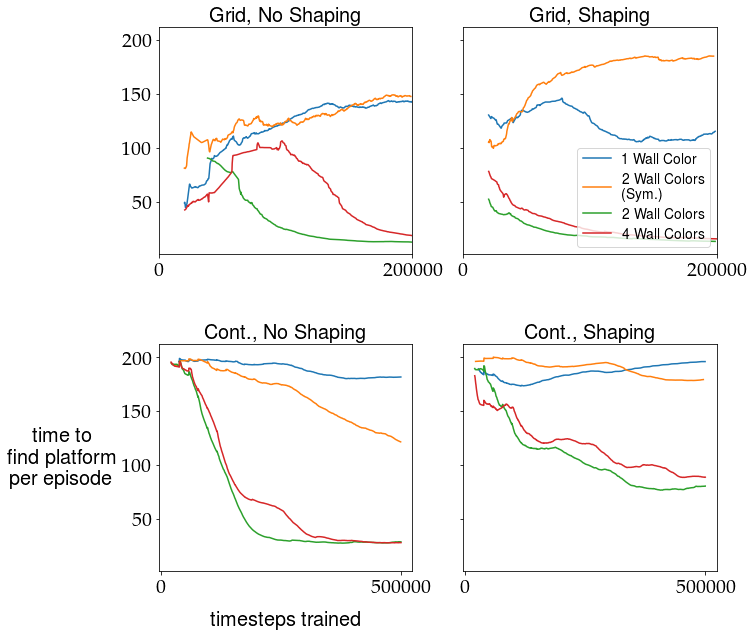

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='row', sharey=True)    

# runs = get_runs(2)

# Grid navigation (first row)
colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 1 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, ax=ax[0, 1], cloud_alpha=0)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 0 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

plot_cloud_from_dict(datas, ax=ax[0, 0], cloud_alpha=0, ignore_first=20000)



# Continuous navigation plots (2nd row)
colors = ['1', '2', '2.5', '4']
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
dist_trial_names = [f'nav_invisible_color_{color}_dist' for color in colors]
none_trial_names = [f'nav_invisible_color_{color}_none' for color in colors]
labels = ['1 Wall Color', '2 Wall Colors \n(Sym.)', '2 Wall Colors', '4 Wall Colors']

for i, trial in enumerate(dist_trial_names):
    average_runs(trial, 'length', label=labels[i], ax=ax[1, 1], ignore_first=90, color=color_cycle[i], cloud_alpha=0,
                ewm=0.001)
for i, trial in enumerate(none_trial_names):
    average_runs(trial, 'length', label=labels[i], ax=ax[1, 0], ignore_first=90, color=color_cycle[i], cloud_alpha=0,
                ewm=0.001)

    
ax[1, 0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
ax[1, 0].set_xlabel('timesteps trained', labelpad=15)
ax[0, 0].set_xlim([0, 200000])

ax[0, 0].set_xticks([0, 200000])
ax[1, 0].set_xticks([0, 500000])

# ax[0, 1].set_xlim([15000, 200000])
# handles, labels = ax[1,0].get_legend_handles_labels()
ax[0, 0].legend(loc='lower right', bbox_to_anchor=(1.5,-0.5), fontsize=12)
# fig.legend(handles, labels, loc='upper left', fontsize=12, bbox_to_anchor=(-0.10, 0.88))

# ax[0, 0].text(30000, 170, 'A', weight='bold')
# ax[0, 1].text(30000, 170, 'B', weight='bold')
# ax[1, 0].text(30000, 30, 'C', weight='bold')
# ax[1, 1].text(30000, 30, 'D', weight='bold')

ax[0, 1].legend(handles, labels, fontsize=14, loc='lower right')

ax[0, 0].set_title('Grid, No Shaping', fontsize=20)
ax[0, 1].set_title('Grid, Shaping', fontsize=20)
ax[1, 0].set_title('Cont., No Shaping', fontsize=20)
ax[1, 1].set_title('Cont., Shaping', fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.savefig(save_folder + '7_2_grid_and_cont_wall_color_shaping_axes', bbox_inches='tight')

## Comparing results using FlexNN model class

Since we rewrote a model class that allows for flexibility of layer sharing and auxiliary task implementation, to ensure that it still replicates the original model results when conditions are the same (2 unshared layers, no auxiliary task), we compare the following results

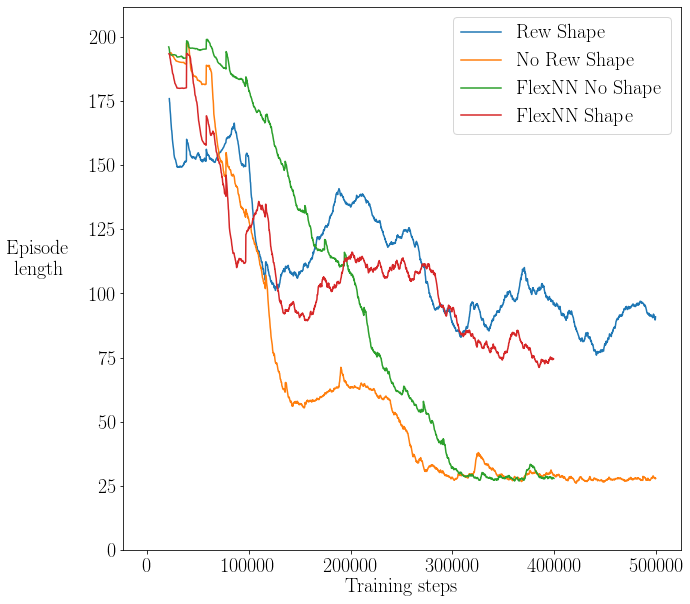

In [ ]:
# exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
exp_names = ['nav_invisible_color_4_dist', 'nav_invisible_color_4_none', 'nav_euclid_start_0', 
             'nav_invisible_shared0',]
label_names = ['Rew Shape', 'No Rew Shape', 'FlexNN No Shape', 
               'FlexNN Shape']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax, label=label_names[i],
                cloud_alpha=0, ignore_first=100)
    
ax.set_xlabel('Training steps')
ax.set_ylabel('Episode \n length', rotation=0, labelpad=50)
ax.legend()
plt.savefig('plots/proof_of_concept/nav_shaping')

## Comparing number of shared layers

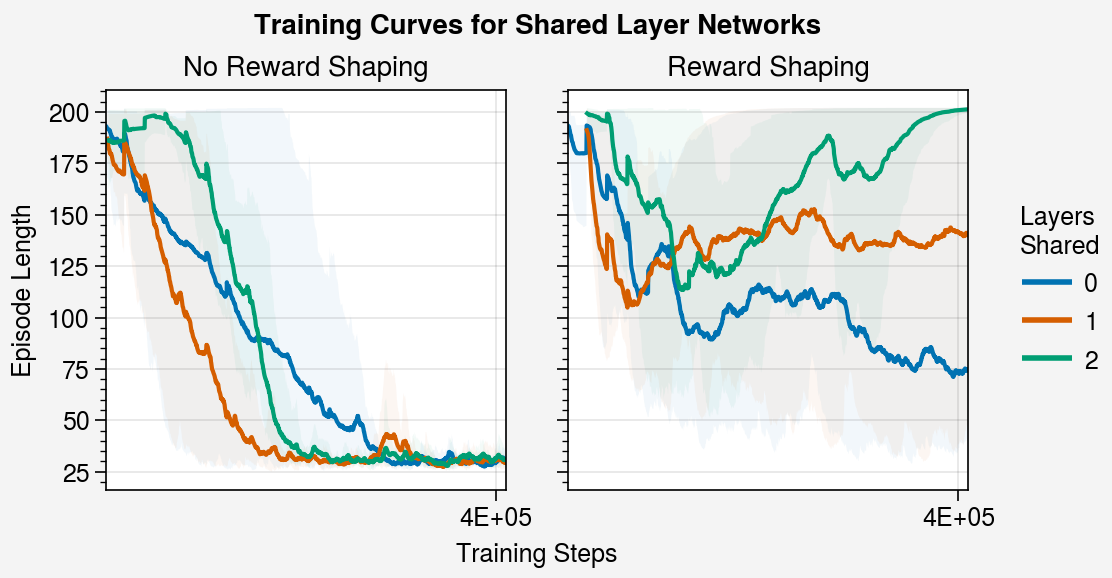

In [8]:
# exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
folder = 'nav_invisible_shared'
shared = [0, 1, 2]
goal_exp_names = [f'{folder}/nav_c4_shared{s}' for s in shared]
dist_exp_names = [f'{folder}/nav_c4_shared{s}.dist' for s in shared]

label_names = ['0', '1', '2']

fig, ax = pplt.subplots(nrows=1, ncols=2, axwidth=2)
hs = []

for i, exp in enumerate(goal_exp_names):
    h = average_runs(exp, 'length', ax=ax[0], label=label_names[i],
        cloud_alpha=0.05, ignore_first=100)
    hs.append(h[0])
    
for i, exp in enumerate(dist_exp_names):
    average_runs(exp, 'length', ax=ax[1], label=label_names[i],
        cloud_alpha=0.05, ignore_first=100)
  
ax.format(
    xticks=[390000],
    suptitle='Training Curves for Shared Layer Networks',
    xformatter='%.E',
    xlabel='Training Steps',
    ylabel='Episode Length',
    title=['No Reward Shaping', 'Reward Shaping'],
)
fig.legend(hs, loc='r', frame=False, center=False, ncols=1,
           label='Layers\nShared', lw=2)

plt.savefig('plots/proof_of_concept/6_4_shared_layers_learning_curves.png')

# Auxiliary Tasks

## Null Task

Here we accidentally formed a null task where the true output value is 0 at every step, but due to random initialization the network does not outputs zeros, so it has some sort of information to learn. This also acts as a regularizer maybe? Seems like this might be something feasible to do theoretical analysis on?

In any case, even the null task has improvements in performance

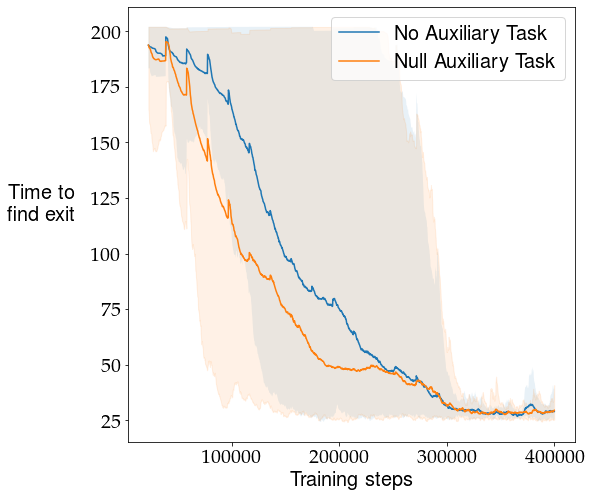

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
average_runs('nav_euclid_start_0', 'length', label='No Auxiliary Task', ax=ax)
average_runs('nav_euclid_start_1', 'length', label='Null Auxiliary Task', ax=ax, color=color_cycle[1])

ax.set_xlabel('Training steps')
ax.set_ylabel('Time to \n find exit', rotation=0, labelpad=50)
ax.legend()
plt.savefig('plots/auxiliary_tasks/null_task')

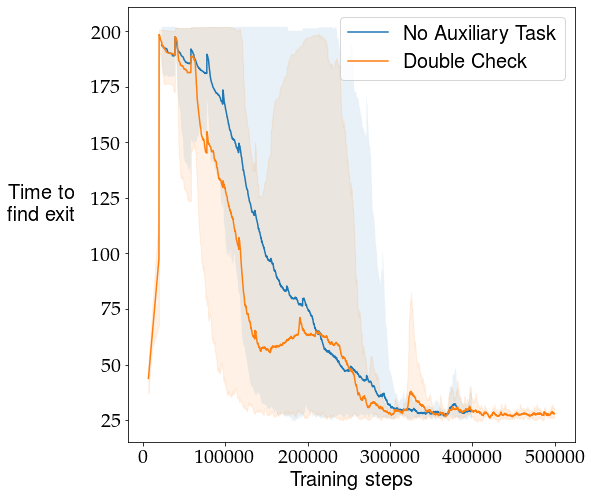

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
average_runs('nav_euclid_start_0', 'length', label='No Auxiliary Task', ax=ax)
average_runs('nav_invisible_color_4_none', 'length', label='Double Check', ax=ax, color=color_cycle[1])

ax.set_xlabel('Training steps')
ax.set_ylabel('Time to \n find exit', rotation=0, labelpad=50)
ax.legend()
# plt.savefig('plots/auxiliary_tasks/null_task')

## Auxiliary Tasks

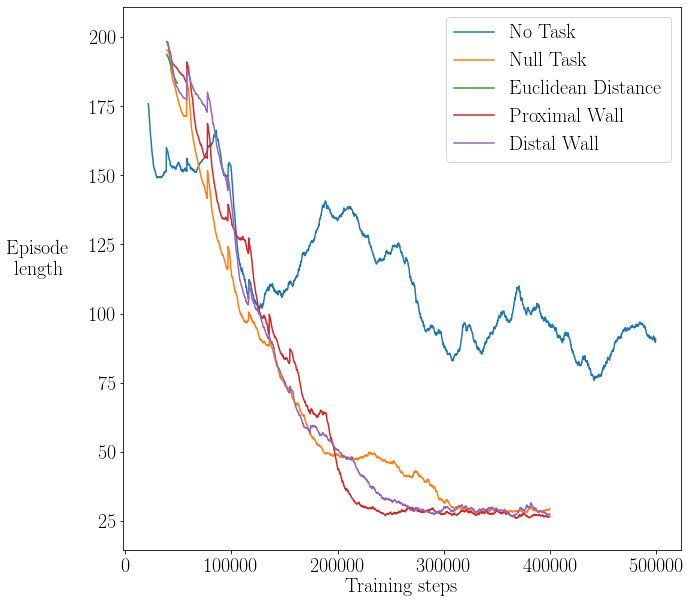

In [21]:
# exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
exp_names = ['nav_invisible_color_4_dist', 'nav_euclid_start_1', 
             'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
label_names = ['No Task', 'Null Task', 'Euclidean Distance', 
               'Proximal Wall', 'Distal Wall']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax, label=label_names[i],
                cloud_alpha=0, ignore_first=100)
    
ax.set_xlabel('Training steps')
ax.set_ylabel('Episode \n length', rotation=0, labelpad=50)
ax.legend()
plt.savefig('plots/auxiliary_tasks/auxiliary_task_summary')

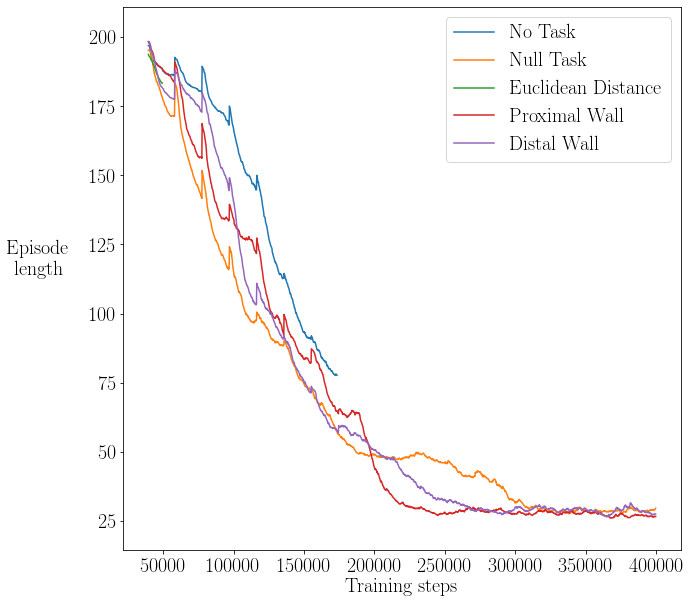

In [4]:
exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
             'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
# exp_names = ['nav_invisible_color_4_dist', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
label_names = ['No Task', 'Null Task', 'Euclidean Distance', 
               'Proximal Wall', 'Distal Wall']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax, label=label_names[i],
                cloud_alpha=0, ignore_first=100)
    
ax.set_xlabel('Training steps')
ax.set_ylabel('Episode \n length', rotation=0, labelpad=50)
ax.legend()
plt.savefig('plots/auxiliary_tasks/auxiliary_task_summary')

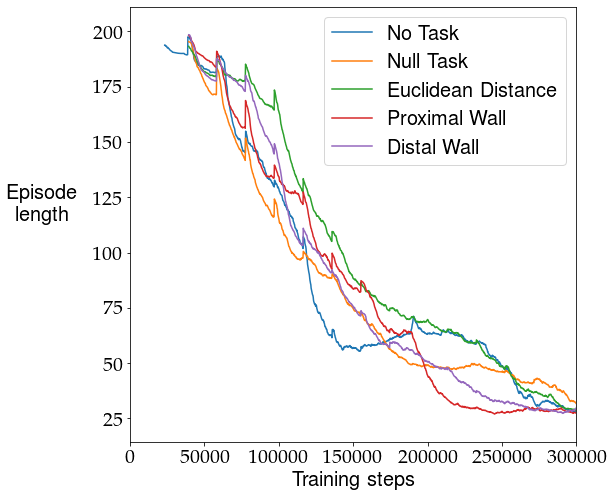

In [11]:
# exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
exp_names = ['nav_invisible_color_4_none', 'nav_euclid_start_1', 
             'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
label_names = ['No Task', 'Null Task', 'Euclidean Distance', 
               'Proximal Wall', 'Distal Wall']

fig, ax = plt.subplots(1, 1, figsize=(8,8))
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax, label=label_names[i],
                cloud_alpha=0, ignore_first=100)
    
ax.set_xlabel('Training steps')
ax.set_ylabel('Episode \n length', rotation=0, labelpad=50)
ax.legend()
ax.set_xlim([0, 300000])
plt.savefig('plots/auxiliary_tasks/auxiliary_task_summary')

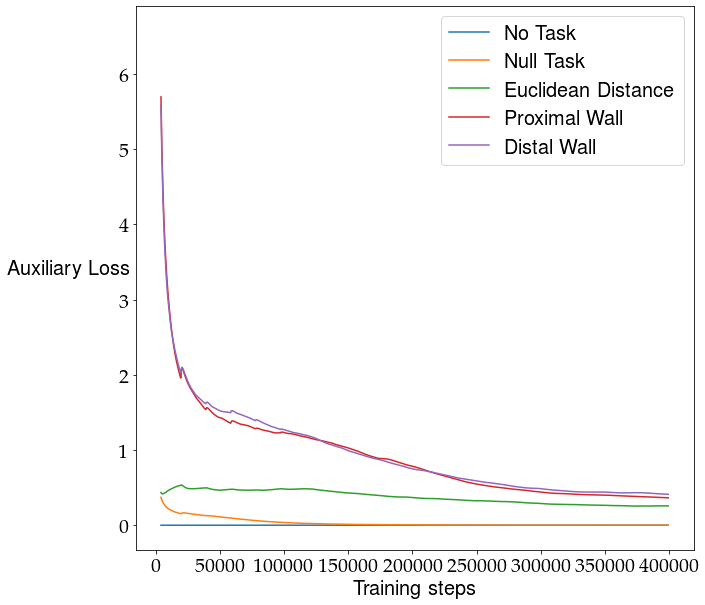

In [5]:
# exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 
#              'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']
exp_names = ['nav_euclid_start_0', 'nav_euclid_start_1', 'nav_euclid_start_2',
            'nav_aux_wall_1', 'nav_aux_wall_3']
label_names = ['No Task', 'Null Task', 'Euclidean Distance', 
               'Proximal Wall', 'Distal Wall']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, exp in enumerate(exp_names):
    average_runs(exp, 'losses/auxiliary_loss', ax=ax, label=label_names[i],
                cloud_alpha=0)
    
ax.set_xlabel('Training steps')
ax.set_ylabel('Auxiliary Loss', rotation=0, labelpad=50)
ax.legend()
# plt.savefig('plots/auxiliary_tasks/auxiliary_task_summary')

## Bumps in learning curve

Note that the bumps in the learning curve are due to the large number of simultaneously running copies of agents that take 200 time steps and end the episode without finding the platform

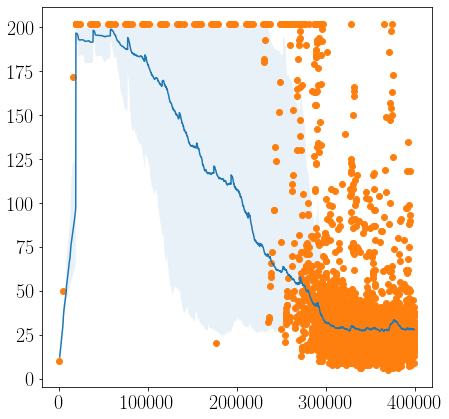

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
average_runs('nav_euclid_start_0', 'length', ax=ax)

df = load_exp_df('nav_euclid_start_0', 0)

length_df = df[df['metric'] == 'charts/episodic_length']

ax.scatter(length_df['step'], length_df['value'])

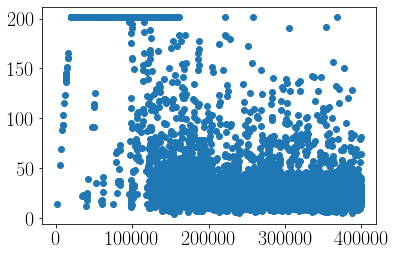

In [19]:

df = load_exp_df('nav_euclid_start_0', 1)

length_df = df[df['metric'] == 'charts/episodic_length']

plt.scatter(length_df['step'], length_df['value'])
# plt.plot(length_df['step'], length_df['value'].ewm(0.01).mean())

## Summary of Aux tasks on a couple tasks (4 colors, 2 symm, proximal poster)

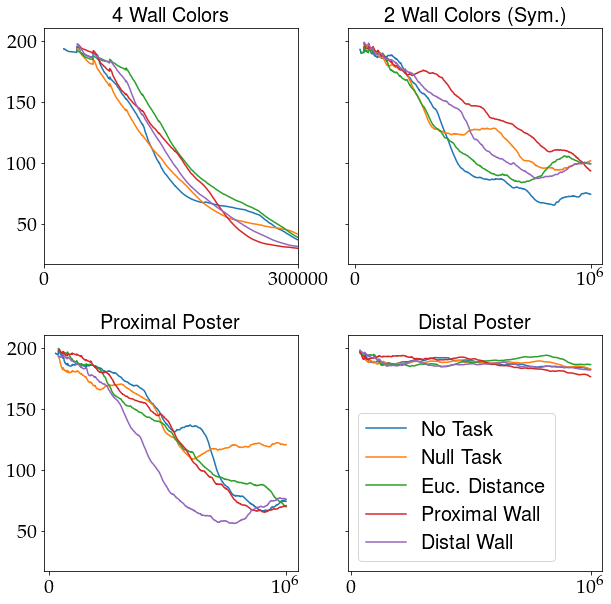

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

label_names = ['No Task', 'Null Task', 'Euc. Distance', 
               'Proximal Wall', 'Distal Wall']

# 4 Wall Colors
exp_names = ['nav_invisible_color_4_none', 'nav_euclid_start_1', 
             'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']

for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[0, 0], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)

# 2 Wall Colors
exp_names = ['nav_euclid_c2_start_0', 'nav_euclid_c2_start_1', 
             'nav_euclid_c2_start_2', 'nav_aux_c2_wall_1', 'nav_aux_c2_wall_3']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[0, 1], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)


exp_names = ['nav_euclid_pproxim_start_0', 'nav_euclid_pproxim_start_1', 
             'nav_euclid_pproxim_start_2', 'nav_aux_pproxim_wall_1', 'nav_aux_pproxim_wall_2']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[1, 0], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)
    
exp_names = ['nav_euclid_pdistal_start_0', 'nav_euclid_pdistal_start_1', 
             'nav_euclid_pdistal_start_2', 'nav_aux_pdistal_wall_1', 'nav_aux_pdistal_wall_2']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[1, 1], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)


ax[0,0].set_xlim([0, 300000])
ax[0,0].set_xticks([0, 300000])
ax[0,1].set_xticks([0, 1e6], ['$0$', '$10^6$'])
ax[1,1].set_xticks([0, 1e6], ['$0$', '$10^6$'])
ax[1,0].set_xticks([0, 1e6], ['$0$', '$10^6$'])
# ax[1,0].set_xlabel('Training steps')
# ax[1,0].set_ylabel('Episode \n length', rotation=0, labelpad=50)
# ax[0,0].legend(bbox_to_anchor=(-0.2, 1))
ax[1,1].legend()

# ax[0,0].text(35000, 50, 'A', fontweight='bold')
# ax[0,1].text(50000, 50, 'B', fontweight='bold')
# ax[1,0].text(120000, 50, 'C', fontweight='bold')
# ax[1,1].text(120000, 50, 'D', fontweight='bold')

ax[0,0].set_title('4 Wall Colors', fontsize=20)
ax[0,1].set_title('2 Wall Colors (Sym.)', fontsize=20)
ax[1,0].set_title('Proximal Poster', fontsize=20)
ax[1,1].set_title('Distal Poster', fontsize=20)
plt.subplots_adjust(hspace=0.3)
plt.savefig('plots/auxiliary_tasks/8_6_multiple_aux_summary', bbox_inches='tight')

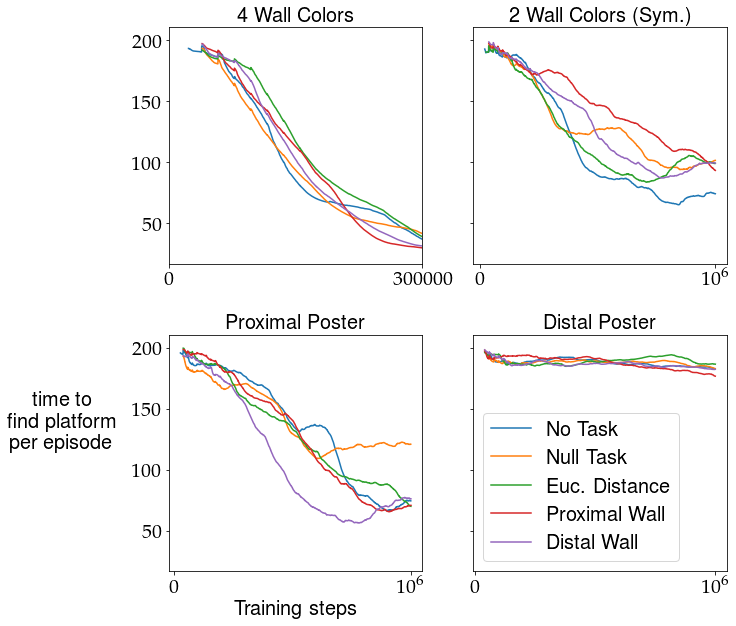

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

label_names = ['No Task', 'Null Task', 'Euc. Distance', 
               'Proximal Wall', 'Distal Wall']

# 4 Wall Colors
exp_names = ['nav_invisible_color_4_none', 'nav_euclid_start_1', 
             'nav_euclid_start_2', 'nav_aux_wall_1', 'nav_aux_wall_3']

for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[0, 0], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)

# 2 Wall Colors
exp_names = ['nav_euclid_c2_start_0', 'nav_euclid_c2_start_1', 
             'nav_euclid_c2_start_2', 'nav_aux_c2_wall_1', 'nav_aux_c2_wall_3']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[0, 1], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)


exp_names = ['nav_euclid_pproxim_start_0', 'nav_euclid_pproxim_start_1', 
             'nav_euclid_pproxim_start_2', 'nav_aux_pproxim_wall_1', 'nav_aux_pproxim_wall_2']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[1, 0], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)
    
exp_names = ['nav_euclid_pdistal_start_0', 'nav_euclid_pdistal_start_1', 
             'nav_euclid_pdistal_start_2', 'nav_aux_pdistal_wall_1', 'nav_aux_pdistal_wall_2']
for i, exp in enumerate(exp_names):
    average_runs(exp, 'length', ax=ax[1, 1], label=label_names[i],
                cloud_alpha=0, ignore_first=100, ewm=0.001)


ax[0,0].set_xlim([0, 300000])
ax[0,0].set_xticks([0, 300000])
ax[0,1].set_xticks([0, 1e6], ['$0$', '$10^6$'])
ax[1,1].set_xticks([0, 1e6], ['$0$', '$10^6$'])
ax[1,0].set_xticks([0, 1e6], ['$0$', '$10^6$'])
ax[1,0].set_xlabel('Training steps')
ax[1,0].set_ylabel('time to\nfind platform\nper episode', rotation=0, labelpad=70)
# ax[0,0].legend(bbox_to_anchor=(-0.2, 1))
ax[1,1].legend()

# ax[0,0].text(35000, 50, 'A', fontweight='bold')
# ax[0,1].text(50000, 50, 'B', fontweight='bold')
# ax[1,0].text(120000, 50, 'C', fontweight='bold')
# ax[1,1].text(120000, 50, 'D', fontweight='bold')

ax[0,0].set_title('4 Wall Colors', fontsize=20)
ax[0,1].set_title('2 Wall Colors (Sym.)', fontsize=20)
ax[1,0].set_title('Proximal Poster', fontsize=20)
ax[1,1].set_title('Distal Poster', fontsize=20)
plt.subplots_adjust(hspace=0.3)
plt.savefig('plots/auxiliary_tasks/8_6_multiple_aux_summary_axes', bbox_inches='tight')

# Testing Null Aux task on other environments

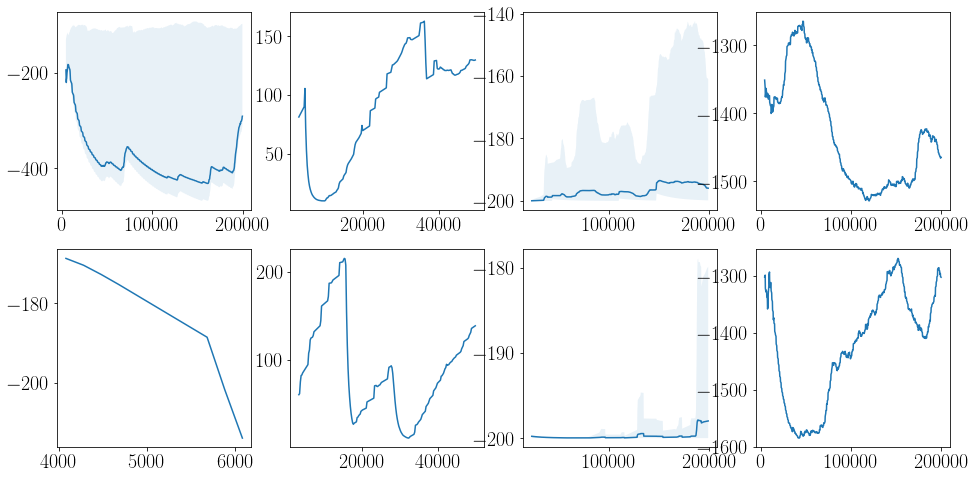

In [5]:
env_names = ['acrobot', 'cartpole', 'mountaincar', 'pendulum']
auxes = ['noaux', 'aux']
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, aux in enumerate(auxes):
    for j, name in enumerate(env_names):
        name = name+'_'+aux
        average_runs(name, ax=ax[i,j])

# Need to recheck some results for new resetting
## nav_c4_aux

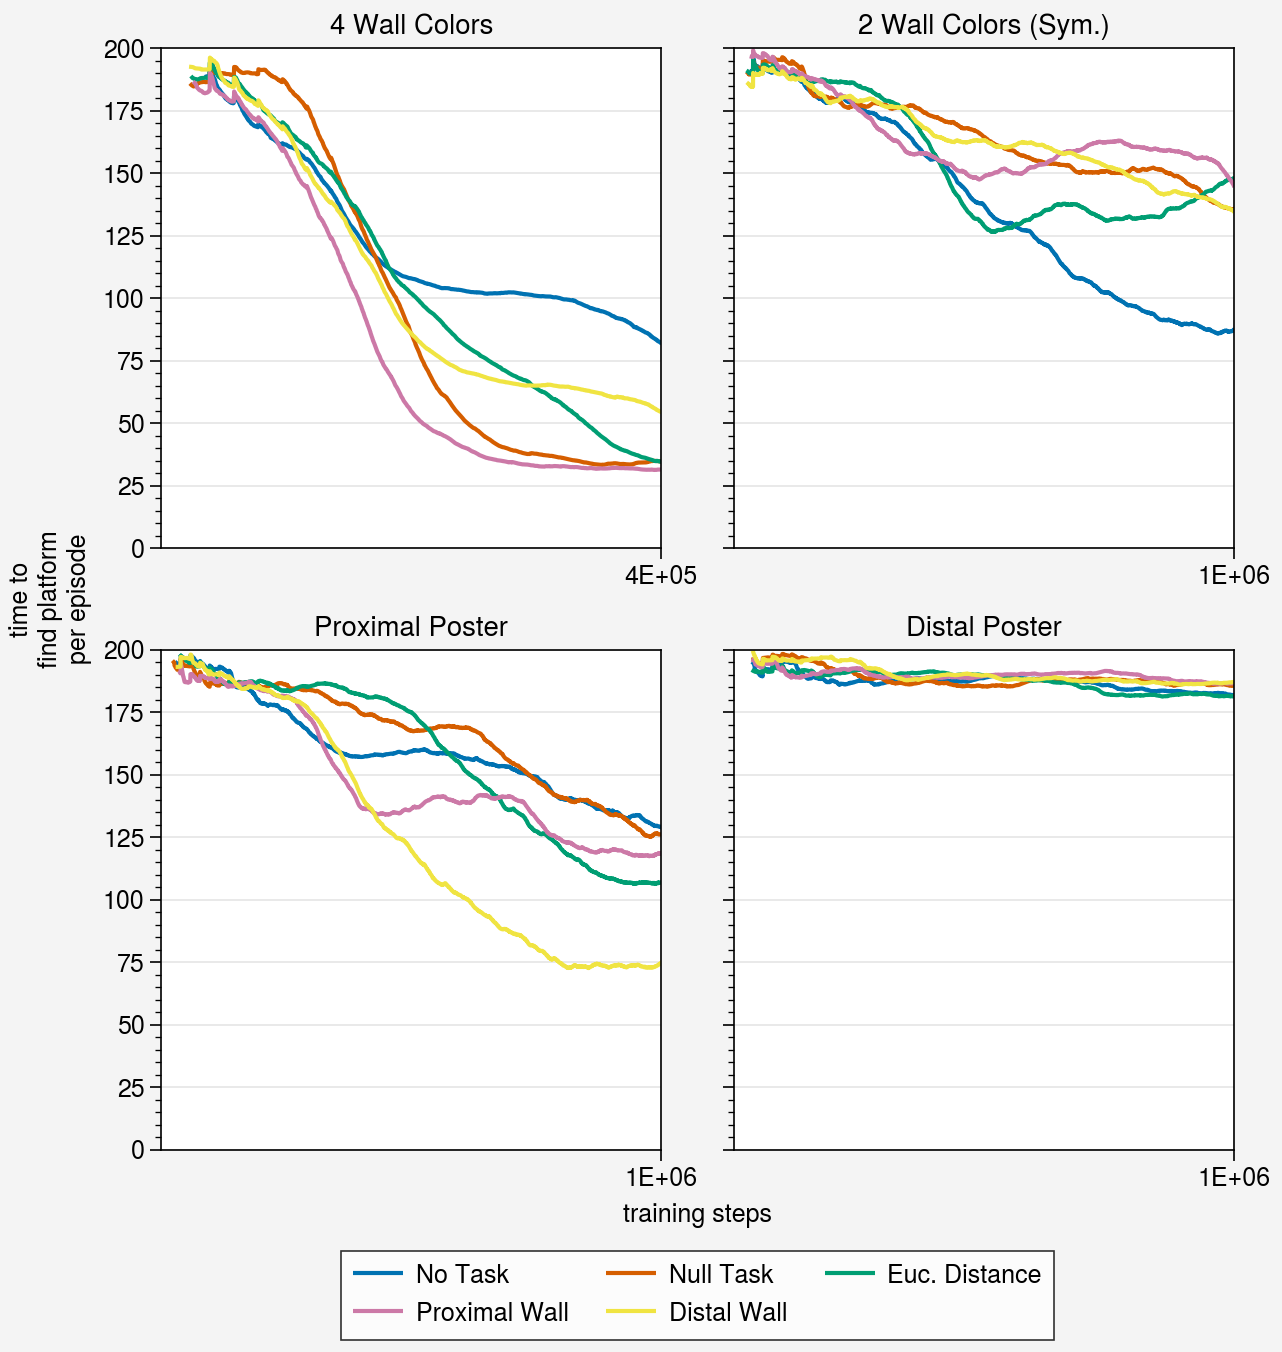

In [22]:
exp_conds = ['c4', 'c2', 'pproxim', 'pdistal']
exp_cond_folders = ['nav_auxiliary_tasks2', 'nav_auxiliary_tasks2', 
                    'nav_poster2', 'nav_poster2']
exp_cond_labels = ['4 Wall Colors', '2 Wall Colors (Sym.)', 'Proximal Poster', 
                   'Distal Poster']
aux_conds = ['auxeuclid0', 'auxeuclid1', 'auxeuclid2', 'auxwall1', 'auxwall3']
paux_conds = ['auxeuclid0', 'auxeuclid1', 'auxeuclid2', 'auxwall1', 'auxwall2']
aux_labels = ['No Task', 'Null Task', 'Euc. Distance', 'Proximal Wall', 'Distal Wall']

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False, span=3)
ax.format(title=exp_cond_labels,
         xformatter='%.E',
         ylim=[0, 200],
         ylabel='time to\nfind platform\nper episode')
ax[2:].format(xlabel='training steps')
ax[1:].format(xticks=[999999], xlim=[0, 1000000])
ax[0].format(xticks=[399999], xlim=[0, 400000])
hs = []
for i, econd in enumerate(exp_conds):
    econd = exp_conds[i]
    folder = exp_cond_folders[i]
    hs.append([])
    
    
    if i > 1:
        aconds = paux_conds
    else:
        aconds = aux_conds
    
    for j, acond in enumerate(aconds):
        acond = aconds[j]
        
        exp = f'{folder}/nav_{econd}_{acond}'
        h = average_runs(exp, 'length', ax=ax[i], label=aux_labels[j], cloud_alpha=0,
                     ignore_first=100, ewm=0.001)
        hs[i].append(h)
        

fig.legend(hs[0], loc='b')
fig.savefig('plots/proof_of_concept/9_1_nav_c4_aux_learning_curves_new.png')

# Network structure variations

In [26]:
%run read_experiments

In [13]:
trial_names = ['nav_pproxim_mlp_t0', 'nav_pproxim_mlp_t1', 'nav_pproxim_mlp_t2', 'nav_pproxim_width16_t0', 'nav_pproxim_width16_t1', 'nav_pproxim_width16_t2', 'nav_pproxim_width2_t0', 'nav_pproxim_width2_t1', 'nav_pproxim_width2_t2', 'nav_pproxim_width32_t0', 'nav_pproxim_width32_t1', 'nav_pproxim_width32_t2', 'nav_pproxim_width4_t0', 'nav_pproxim_width4_t1', 'nav_pproxim_width4_t2', 'nav_pproxim_width8_t0', 'nav_pproxim_width8_t1', 'nav_pproxim_width8_t2']
# num = 'nav_pproxim_mlp_t0'.split('_')[-1]
trial_nums = [item.split('_')[-1] for item in trial_names]
re.search('\d+', num)[0]

'0'

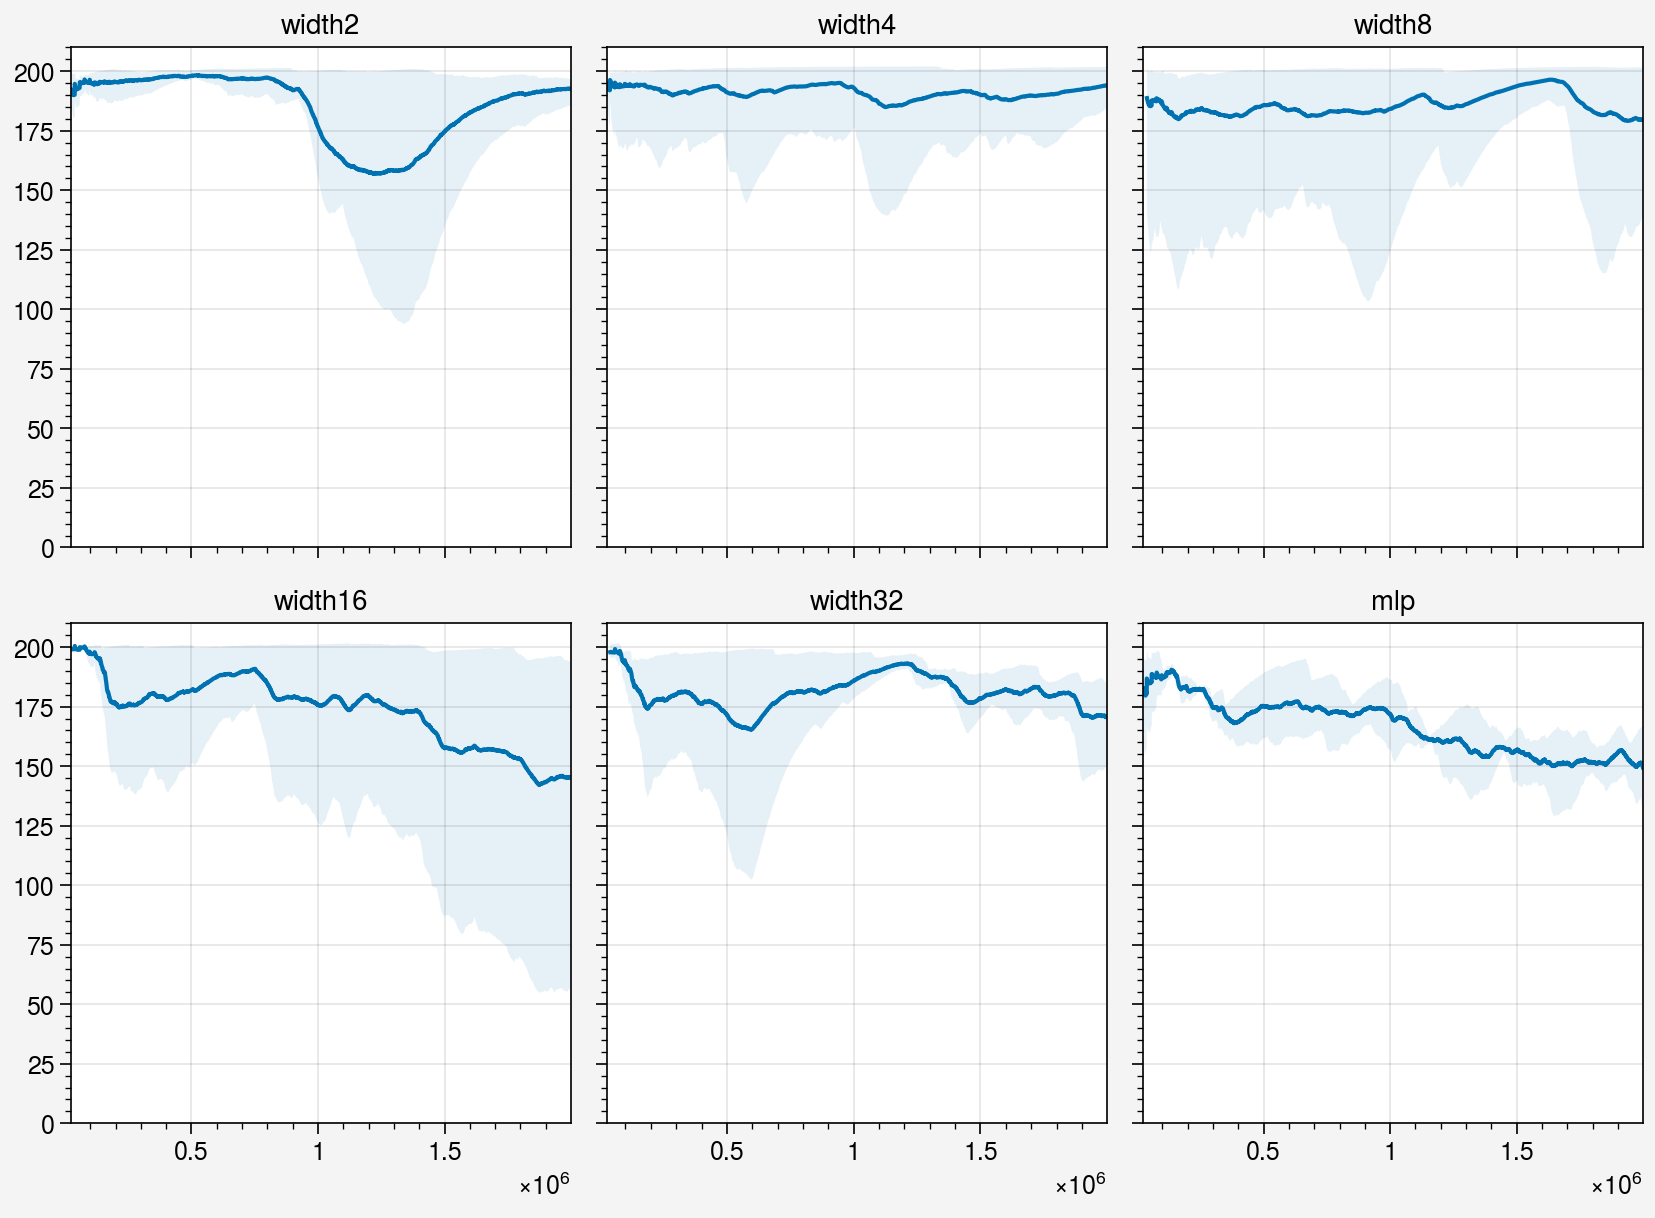

In [9]:
suffixes = ['width2', 'width4', 'width8', 'width16', 'width32', 'mlp']
fig, ax = pplt.subplots(nrows=2, ncols=3, share=True)
ax.format(title=suffixes, ylim=[0, 210])
for i, suffix in enumerate(suffixes):
    exp = f'nav_poster_netstructure/nav_pproxim_{suffix}'
    average_runs(exp, 'length', ax=ax[i], ignore_first=100, ewm=0.001)

In [79]:
exp = 'nav_poster_netstructure/nav_pproxim_width16'
xs, ys, xmin, xmax = average_runs(exp, 'length', ret=True)

print(ys[:, 100:].min(axis=1))
print(ys[:, 100:].argmin(axis=1))
print(ys[:, 100:].argmin(axis=1) / ys.shape[1] * 4165)

[143.50044889 150.03699665  45.73228067]
[9248  715 9179]
[3859.12433624  298.36439235 3830.33112915]


In [56]:
%run model_evaluation
%run read_experiments

In [60]:
exp_name = 'nav_pproxim_width2_t2'
model_name = 'nav_poster_netstructure/nav_pproxim_width2'
model, obs_rms = load_checkpoint(exp_name, 2700)
_, _, kwargs = load_model_and_env(model_name, 2)

eps = evalu(model, obs_rms, n=10, env_kwargs=kwargs, verbose=1)

In [80]:
exp_name = 'nav_pproxim_width16_t2'
model_name = 'nav_poster_netstructure/nav_pproxim_width2'
model, obs_rms = load_checkpoint(exp_name, 3800)
_, _, kwargs = load_model_and_env(model_name, 2)

eps = evalu(model, obs_rms, n=10, env_kwargs=kwargs, verbose=1)

 Evaluation using 10 episodes: mean reward 1.00000



## Batch 200

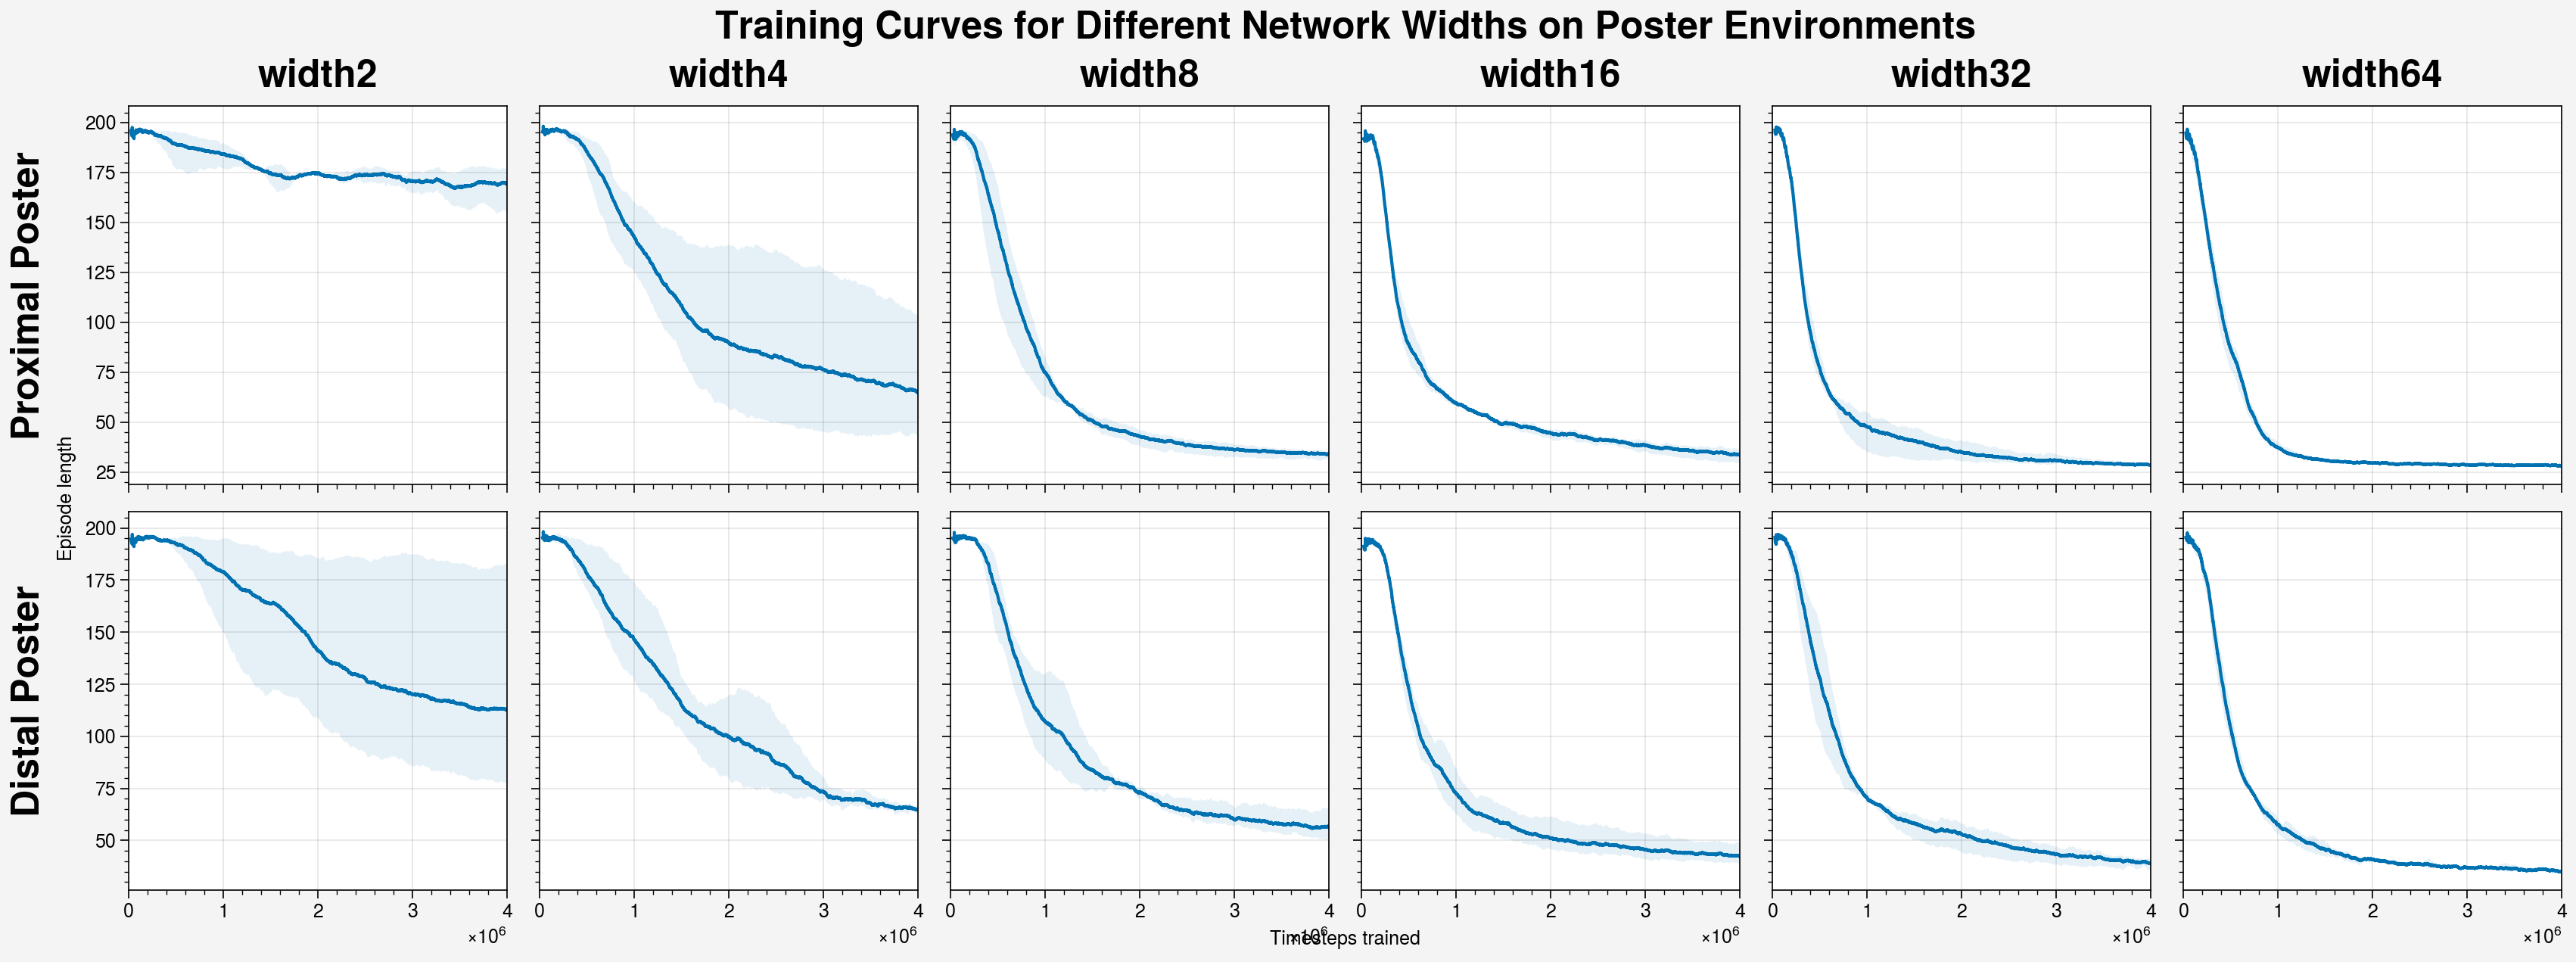

In [5]:
suffixes = ['width2', 'width4', 'width8', 'width16', 'width32', 'width64']
proxim_exp_names = [f'nav_poster_netstructure/nav_pproxim_{width}batch200' for width in suffixes]
distal_exp_names = [f'nav_poster_netstructure/nav_pdistal_{width}batch200' for width in suffixes]

fig, ax = pplt.subplots(nrows=2, ncols=len(suffixes))

ax.format(
    toplabels=suffixes,
    leftlabels=['Proximal Poster', 'Distal Poster'],
    xlabel='Timesteps trained', 
    ylabel='Episode length',
    rc_kw={'toplabel.size': 18, 'leftlabel.size': 18, 'suptitle.size': 18},
    suptitle='Training Curves for Different Network Widths on Poster Environments',
    xlim=[0, 4000000]
)
for i in range(len(suffixes)):
    average_runs(proxim_exp_names[i], 'length', ax=ax[0, i], ignore_first=100, ewm=0.001)
    average_runs(distal_exp_names[i], 'length', ax=ax[1, i], ignore_first=100, ewm=0.001)
    
fig.savefig('plots/proof_of_concept/10_1_batch200_poster_training_curves.png')